![Practicum AI Logo image](https://github.com/PracticumAI/practicumai.github.io/blob/main/images/logo/PracticumAI_logo_250x50.png?raw=true) <img src="https://github.com/PracticumAI/practicumai.github.io/blob/84b04be083ca02e5c7e92850f9afd391fc48ae2a/images/icons/practicumai_computer_vision.png?raw=true" alt="Practicum AI: Computer Vision icon" align="right" width=50>
***

# Transfer Learning Implementation

Welcome back! In our previous exercise [01_transfer_learning_fine_tuning.ipynb](01_transfer_learning_fine_tuning.ipynb), we introduced the core concepts of **transfer learning** and experimented with **fine-tuning**. We saw how leveraging pre-trained models can significantly boost performance and reduce training time compared to starting from scratch.

In this notebook we'll expand into adapting powerful pre-trained language models for specific Natural Language Processing (NLP) tasks, focusing on two other, important transfer learning strategies, **feature extraction** and **low-rank adaptation**. We'll:

* Implement **Feature Extraction** using a pre-trained transformer model for text classification.
* Look closer at how to freeze the base model and train only a new classification head.
* Implement **LoRA (Low-Rank Adaptation)**, a Parameter-Efficient Fine-Tuning (PEFT) technique, to adapt the same pre-trained transformer.
* Understand how LoRA modifies the model and drastically reduces the number of trainable parameters.
* Directly compare the results and efficiency of feature extraction versus LoRA on the same NLP task.

## A Direct Comparison

To make the comparison between Feature Extraction and LoRA as clear as possible, we will:

1.  Use the **same base pre-trained model** [DistilBERT - `distilbert-base-uncased`](https://huggingface.co/distilbert/distilbert-base-uncased) as the starting point for both methods.
2.  Apply both techniques to the **same text classification task** (e.g., Text Classification using the [Crop Market News Classification](https://www.kaggle.com/datasets/mcwemzy/crop-market-news-classification)). This dataset is hosted on the fantastic model zoo site, [Kaggle.com](kaggle.com)!
3.  Use the **same dataset** for training and evaluation in both parts.

This setup will allow us to directly observe the differences in implementation complexity, performance metrics, and the number of parameters trained.

### Prerequisites and Setup

* **Conceptual Understanding:** Ensure you're comfortable with the basic ideas of transfer learning, pre-trained models, and fine-tuning as covered in [01_transfer_learning_fine_tuning.ipynb](01_transfer_learning_fine_tuning.ipynb).
* **Deep Learning Fundamentals:** As with the previous exercise a thorough understanding of how Large Language Models (LLMs) work is not required, but it is necessary to have a basic understanding of concepts like parameters, hyperparameters, and other deep learning fundamentals. If you do want to learn more about how LLMs work, we recommend NVidia's [Deep Learning Institute](https://developer.nvidia.com/dli) course on [Introduction to Transformer-Based Natural Language Processing](https://learn.nvidia.com/courses/course-detail?course_id=course-v1:DLI+S-FX-08+V1). This course is free and provides a solid foundation in the principles of transformers and their applications in NLP.

## How to use this notebook's `FIX_ME`s

In this notebook, you'll find sections marked with:

```
# FIX_ME: <description of what to do>
```

These are places where you need to fill in missing code or make adjustments. The goal is to reinforce the key implementation steps for each technique.

If you get stuck, review the preceding explanations, check the documentation for the libraries used (PyTorch, Hugging Face), or consult the course's [GitHub Discussions page](https://github.com/orgs/PracticumAI/discussions) for hints and help from peers and instructors.

Let's get started with adapting our language model!


## 1. Import the libraries we will use

As always, we will start by importing the libraries we will use in this notebook.

In [1]:
import os

import pytorch_lightning as pl

import torch
from peft import LoraConfig, TaskType, get_peft_model
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint
from torch.optim import AdamW
from torch.utils.data import DataLoader
from torchmetrics import Accuracy, F1Score
from transformers import (AutoModelForSequenceClassification,
                          DataCollatorWithPadding)

import helpers

#### Check for GPU availability

This cell will check that everything is configured correctly to use your GPU. If everything is correct, you should see something like: 

    Using GPU: type of GPU

If you see:
    
    Using CPU
    
Either you do not have a GPU or the kernel is not correctly configured to use it. You might be able to run this notebook, but some sections will take a loooooong time!

In [2]:
# Check for GPU availability
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"Using GPU: {torch.cuda.get_device_name(0)}")
else:
    device = torch.device("cpu")
    print("Using CPU")

Using GPU: NVIDIA A100-SXM4-80GB


### Set HuggingFace home and tokenizer parallelism

By default, HuggingFace tools download models, data, and other things to your home directory at `~/.cache/huggingface`. Depending on the storage setup, that might not be the best place.

To change the path, we can set the `HF_HOME` environment variable.

Additionally, in this notebook, we use parallel data loaders by setting the number of workers. The HuggingFace `tokenizers` module also parallelizes the tokenization process (converting the text into numbers to feed into the model). When both are used, this can cause issues. Since tokenization is relatively quick, we'lll turn that off by setting `TOKENIZERS_PARALLELISM=false`

In [3]:
# Set the cache directory for HuggingFace
# This is where the models will be downloaded and stored
# This code sets the cache directory to a folder named "cache"
# in the current working directory.
# If the folder does not exist, it creates it
os.environ["HF_HOME"] = os.path.join(os.getcwd(), "cache")
if not os.path.exists(os.path.join(os.getcwd(), "cache")):
    os.makedirs(os.path.join(os.getcwd(), "cache"))

print(f"Cache directory set to: {os.getenv("HF_HOME")}")

os.environ["TOKENIZERS_PARALLELISM"] = "false"
print(f"Tokenizers parallelism set to {os.getenv("TOKENIZERS_PARALLELISM")} ")

Cache directory set to: /lustre/fs0/bsc4892/magitz/transfer_learning/cache
Tokenizers parallelism set to false 


## 2. Getting the data

This notebook's dataset is the [Crop Market News Classification](https://www.kaggle.com/datasets/mcwemzy/crop-market-news-classification) dataset. This dataset contains crop market news articles and their corresponding categories. The goal is to classify the articles into their respective categories using both Feature Extraction and LoRA.

In [4]:
# Download the dataset, extract it to the data folder and remove the zip file
download_url = "https://data.rc.ufl.edu/pub/practicum-ai/Transfer_Learning/"
file_name = "crop_market_news.zip"
data_path = "crop_data"
data_file_name = "Crop.Market.News.Classification.arff"

# Paths to dataset
dataset = os.path.join(data_path, data_file_name)

# Download and extract the dataset
helpers.download_and_extract_data(download_url, file_name, data_path, [data_file_name])

Data is already downloaded.


## 3. Looking at the data

The dataset contains a number of columns, but we will only use the `text` and `label` columns. The `text` column contains the news articles, and the `label` column contains the corresponding categories.

In [5]:
df, label2id, id2label, num_labels = helpers.load_dataset(dataset)

Loaded DataFrame shape: (217, 2)
Number of classes: 2
Label mappings created:
  label2id: {'corn': 0, 'wheat': 1}
  id2label: {0: 'corn', 1: 'wheat'}

DataFrame Head:
                                                text category  label
0  The corn market is expected to rise due to inc...     corn      0
1  Wheat prices fall as harvest yields exceed exp...    wheat      1
2   Traders predict a bumper crop for corn this year     corn      0
3  Farmers struggle to keep up with demand for wheat    wheat      1
4  USDA reports higher-than-expected corn yields ...     corn      0

DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 217 entries, 0 to 216
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   text      217 non-null    object
 1   category  217 non-null    object
 2   label     217 non-null    int64 
dtypes: int64(1), object(2)
memory usage: 5.2+ KB

Label Distribution:
label
1    116
0    101
Name: count, 

## 4. Set up the model and tokenizer

We will use the `bert-base-uncased` model and tokenizer from Hugging Face. BERT *(Bidirectional Encoder Representations from Transformers)* is pre-trained on a large corpus of English text and is designed to handle uncased text (i.e., it does not differentiate between uppercase and lowercase letters), making it ideal for our task. We will also set up the training arguments for both Feature Extraction and LoRA.

In [23]:
model_name = "bert-base-uncased"  # Change to your preferred model
train_ds, eval_ds, tokenizer = helpers.prepare_data(df, model_name)


Converted to Hugging Face Dataset:
Dataset({
    features: ['text', 'label'],
    num_rows: 217
})

Split into Train and Validation Sets:
  Training examples: 173
  Validation examples: 44
Dataset({
    features: ['text', 'label'],
    num_rows: 173
})


Map:   0%|          | 0/173 [00:00<?, ? examples/s]

Map:   0%|          | 0/44 [00:00<?, ? examples/s]

## 5. Set up the training parameters



In [24]:
# Set the number of workers to use for data loading
num_workers = None  # To manually set the number of workers change this to an integer

if num_workers is None:
    # Check if Slurm is being used
    # If Slurm is being used, set the number of workers to SLURM_CPUS_PER_TASK
    # If Slurm is not being used, set the number of workers to the number of available CPU cores
    if os.getenv("SLURM_CPUS_PER_TASK") is not None:
        num_workers = int(os.getenv("SLURM_CPUS_PER_TASK"))
        print(f"Using {num_workers} workers for data loading.")
    else:
        num_workers = os.cpu_count()
        print(f"Using {num_workers} workers for data loading.")

Using 16 workers for data loading.


In [25]:
# Setting up models for LoRA and Feature Extraction
batch_size = 32
# --- LoRA Setup ---
# Load base model for LoRA
base_model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=2,  # Adjust based on your classification task
    return_dict=True,
)

# Define LoRA configuration
lora_config = LoraConfig(
    r=16,  # Rank of the update matrices
    lora_alpha=32,  # Scaling factor
    target_modules=["query", "key", "value"],  # Which modules to apply LoRA to
    lora_dropout=0.1,
    bias="none",
    task_type=TaskType.SEQ_CLS,  # For sequence classification tasks
)

# Create LoRA model
lora_model = get_peft_model(base_model, lora_config)
print(
    f"LoRA model setup complete. Trainable parameters: {sum(p.numel() for p in lora_model.parameters() if p.requires_grad)}"
)

# --- Feature Extraction Setup ---
# Load the base model for feature extraction
feature_extractor_model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=2,  # Adjust based on your classification task
    return_dict=True,
)

# Freeze all parameters
for param in feature_extractor_model.parameters():
    param.requires_grad = False

# Unfreeze just the classification head for fine-tuning
for param in feature_extractor_model.classifier.parameters():
    param.requires_grad = True

# Create dataloaders
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
train_dataloader = DataLoader(
    train_ds,
    shuffle=True,
    batch_size=batch_size,
    collate_fn=data_collator,
    num_workers=num_workers,
)
eval_dataloader = DataLoader(
    eval_ds, batch_size=batch_size, collate_fn=data_collator, num_workers=num_workers
)

print(
    f"Feature extraction model setup complete. Trainable parameters: {sum(p.numel() for p in feature_extractor_model.parameters() if p.requires_grad)}"
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


LoRA model setup complete. Trainable parameters: 886274
Feature extraction model setup complete. Trainable parameters: 1538


## 6. Training the models

We will train two models: one using Feature Extraction and the other using LoRA. We will use the same training arguments for both models to ensure a fair comparison. The main difference will be in the training process: 
A. For Feature Extraction, we will freeze the base model and train only the classification head.
B. For LoRA, we will use the LoRA technique to adapt the entire model. 

We will evaluate both models on the validation set and compare their performance in the section 7.

In [29]:
# Define a PyTorch Lightning Module
class TextClassificationModule(pl.LightningModule):
    def __init__(self, model, tokenizer, learning_rate=5e-5):
        super().__init__()
        self.model = model
        self.tokenizer = tokenizer
        self.learning_rate = learning_rate
        self.accuracy = Accuracy(
            task="multiclass", num_classes=2
        )  # Adjust num_classes as needed
        self.f1_score = F1Score(
            num_classes=2, average="weighted", task="multiclass"
        )  # Adjust num_classes as needed
        self.history = {
            "train_loss": [],
            "val_loss": [],
            "train_acc": [],
            "val_acc": [],
            "train_f1": [],
            "val_f1": [],
        }  # Custom history variable

    def forward(self, input_ids, attention_mask, labels=None):
        return self.model(
            input_ids=input_ids, attention_mask=attention_mask, labels=labels
        )

    def training_step(self, batch, batch_idx):
        outputs = self(**batch)
        loss = outputs.loss
        preds = torch.argmax(outputs.logits, dim=-1)
        acc = self.accuracy(preds, batch["labels"])
        self.history["train_loss"].append(loss.item())  # Store training loss
        self.history["train_acc"].append(acc.item())  # Store training accuracy
        self.history["train_f1"].append(self.f1_score(preds, batch["labels"]).item())
        self.log("train_loss", loss, prog_bar=True)
        self.log("train_acc", acc, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        outputs = self(**batch)
        loss = outputs.loss
        logits = outputs.logits
        preds = torch.argmax(logits, dim=-1)
        acc = self.accuracy(preds, batch["labels"])
        self.history["val_loss"].append(loss.item())  # Store validation loss
        self.history["val_acc"].append(acc.item())  # Store validation accuracy
        self.history["val_f1"].append(self.f1_score(preds, batch["labels"]).item())
        self.log("val_loss", loss, prog_bar=True)
        self.log("val_acc", acc, prog_bar=True)
        return loss

    def configure_optimizers(self):
        optimizer = AdamW(self.parameters(), lr=self.learning_rate)
        return optimizer

    def predict_step(self, batch, batch_idx):
        """
        Defines the outputs for the predict method.
        """
        outputs = self(**batch)
        return {"logits": outputs.logits, "labels": batch["labels"]}

In [30]:
# Wrap the models in PyTorch Lightning modules
lora_module = TextClassificationModule(lora_model, tokenizer)
feature_extractor_module = TextClassificationModule(feature_extractor_model, tokenizer)

# Define callbacks for checkpointing and early stopping
checkpoint_callback = ModelCheckpoint(monitor="val_loss", save_top_k=1, mode="min")
early_stopping_callback = EarlyStopping(monitor="val_loss", patience=3, mode="min")

# Initialize the PyTorch Lightning Trainer
trainer = Trainer(
    max_epochs=10,
    accelerator="gpu" if torch.cuda.is_available() else "cpu",
    callbacks=[checkpoint_callback, early_stopping_callback],
    log_every_n_steps=1,
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [31]:
# Train the LoRA model
print("Training LoRA model...")
trainer.fit(lora_module, train_dataloader, eval_dataloader)

# Evaluate the models
print("Evaluating LoRA model...")
trainer.validate(lora_module, eval_dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type                               | Params | Mode 
------------------------------------------------------------------------
0 | model    | PeftModelForSequenceClassification | 110 M  | train
1 | accuracy | MulticlassAccuracy                 | 0      | train
2 | f1_score | MulticlassF1Score                  | 0      | train
------------------------------------------------------------------------
886 K     Trainable params
109 M     Non-trainable params
110 M     Total params
441.480   Total estimated model params size (MB)
366       Modules in train mode
232       Modules in eval mode
SLURM auto-requeueing enabled. Setting signal handlers.


Training LoRA model...


Sanity Checking: |                                                                                            …

Training: |                                                                                                   …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

`Trainer.fit` stopped: `max_epochs=10` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Evaluating LoRA model...


Validation: |                                                                                                 …

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         val_acc                    1.0
        val_loss            0.08974481374025345
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'val_loss': 0.08974481374025345, 'val_acc': 1.0}]

In [32]:
# Train the Feature Extraction model
print("Training Feature Extraction model...")
trainer.fit(feature_extractor_module, train_dataloader, eval_dataloader)

print("Evaluating Feature Extraction model...")
trainer.validate(feature_extractor_module, eval_dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type                          | Params | Mode 
-------------------------------------------------------------------
0 | model    | BertForSequenceClassification | 109 M  | eval 
1 | accuracy | MulticlassAccuracy            | 0      | train
2 | f1_score | MulticlassF1Score             | 0      | train
-------------------------------------------------------------------
1.5 K     Trainable params
109 M     Non-trainable params
109 M     Total params
437.935   Total estimated model params size (MB)
2         Modules in train mode
231       Modules in eval mode
SLURM auto-requeueing enabled. Setting signal handlers.


Training Feature Extraction model...


Sanity Checking: |                                                                                            …

`Trainer.fit` stopped: `max_epochs=10` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Evaluating Feature Extraction model...


Validation: |                                                                                                 …

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         val_acc            0.4545454680919647
        val_loss            0.6999784708023071
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'val_loss': 0.6999784708023071, 'val_acc': 0.4545454680919647}]

## 7. Evaluating the models

After training both models, we will evaluate their performance on the validation set. We will compare the accuracy, loss, and examine how the training process proceeded with respect to each approach's trainable parameters. This will help us understand the trade-offs between Feature Extraction and LoRA in terms of performance and efficiency.

Evaluating and comparing models...


Metric          LoRA       Feature Extraction  
accuracy        0.4773   0.4545
precision       0.7569   0.2066
recall          0.4773   0.4545
f1              0.3322   0.2841
auc             0.6167   0.4458

Inference time (s):
LoRA: 0.6447
Feature Extraction: 0.6304

Trainable parameters:
LoRA: 886,274
Feature Extraction: 1,538


/lustre/fs0/bsc4892/share/conda/envs/transfer_learning2/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


<Figure size 640x480 with 0 Axes>

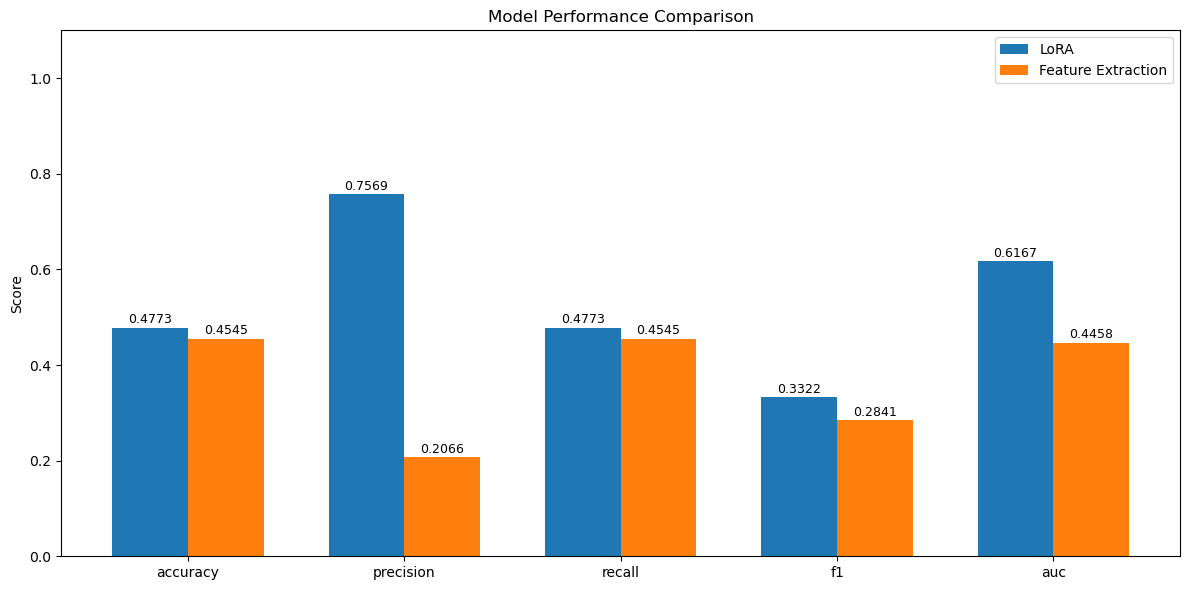

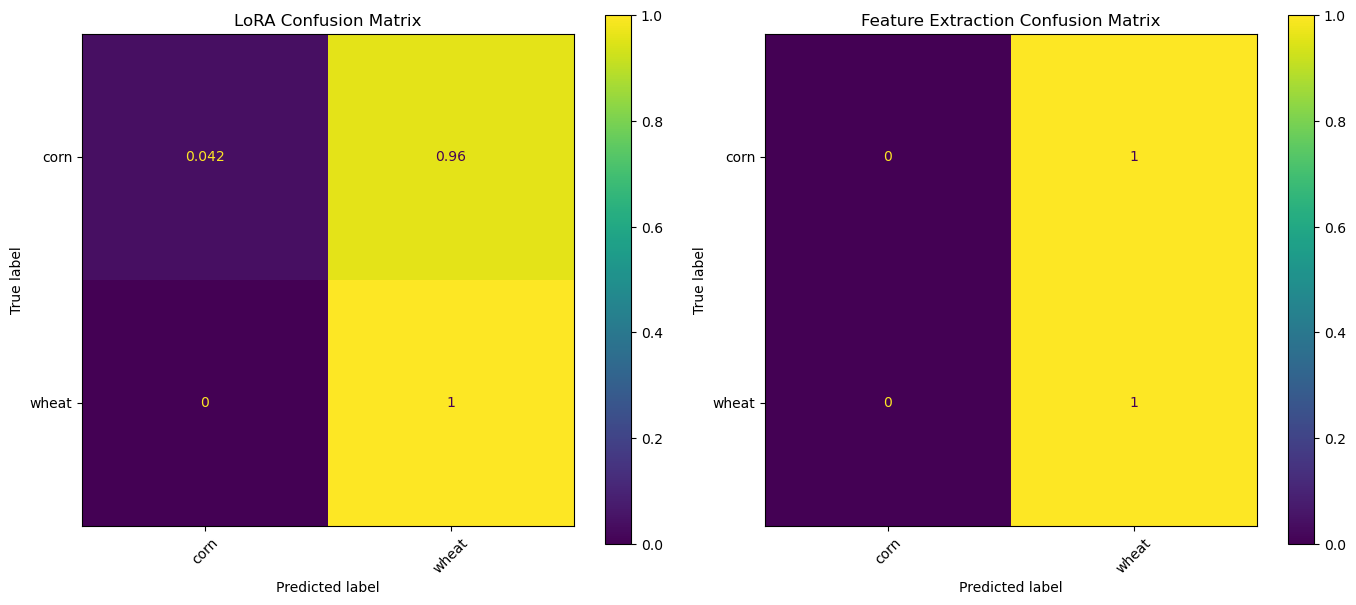

In [13]:
# Evaluate and compare models

print("Evaluating and comparing models...")
metrics = helpers.evaluate_and_compare(
    lora_model, feature_extractor_model, eval_dataloader, device, id2label
)



Plotting learning curves...


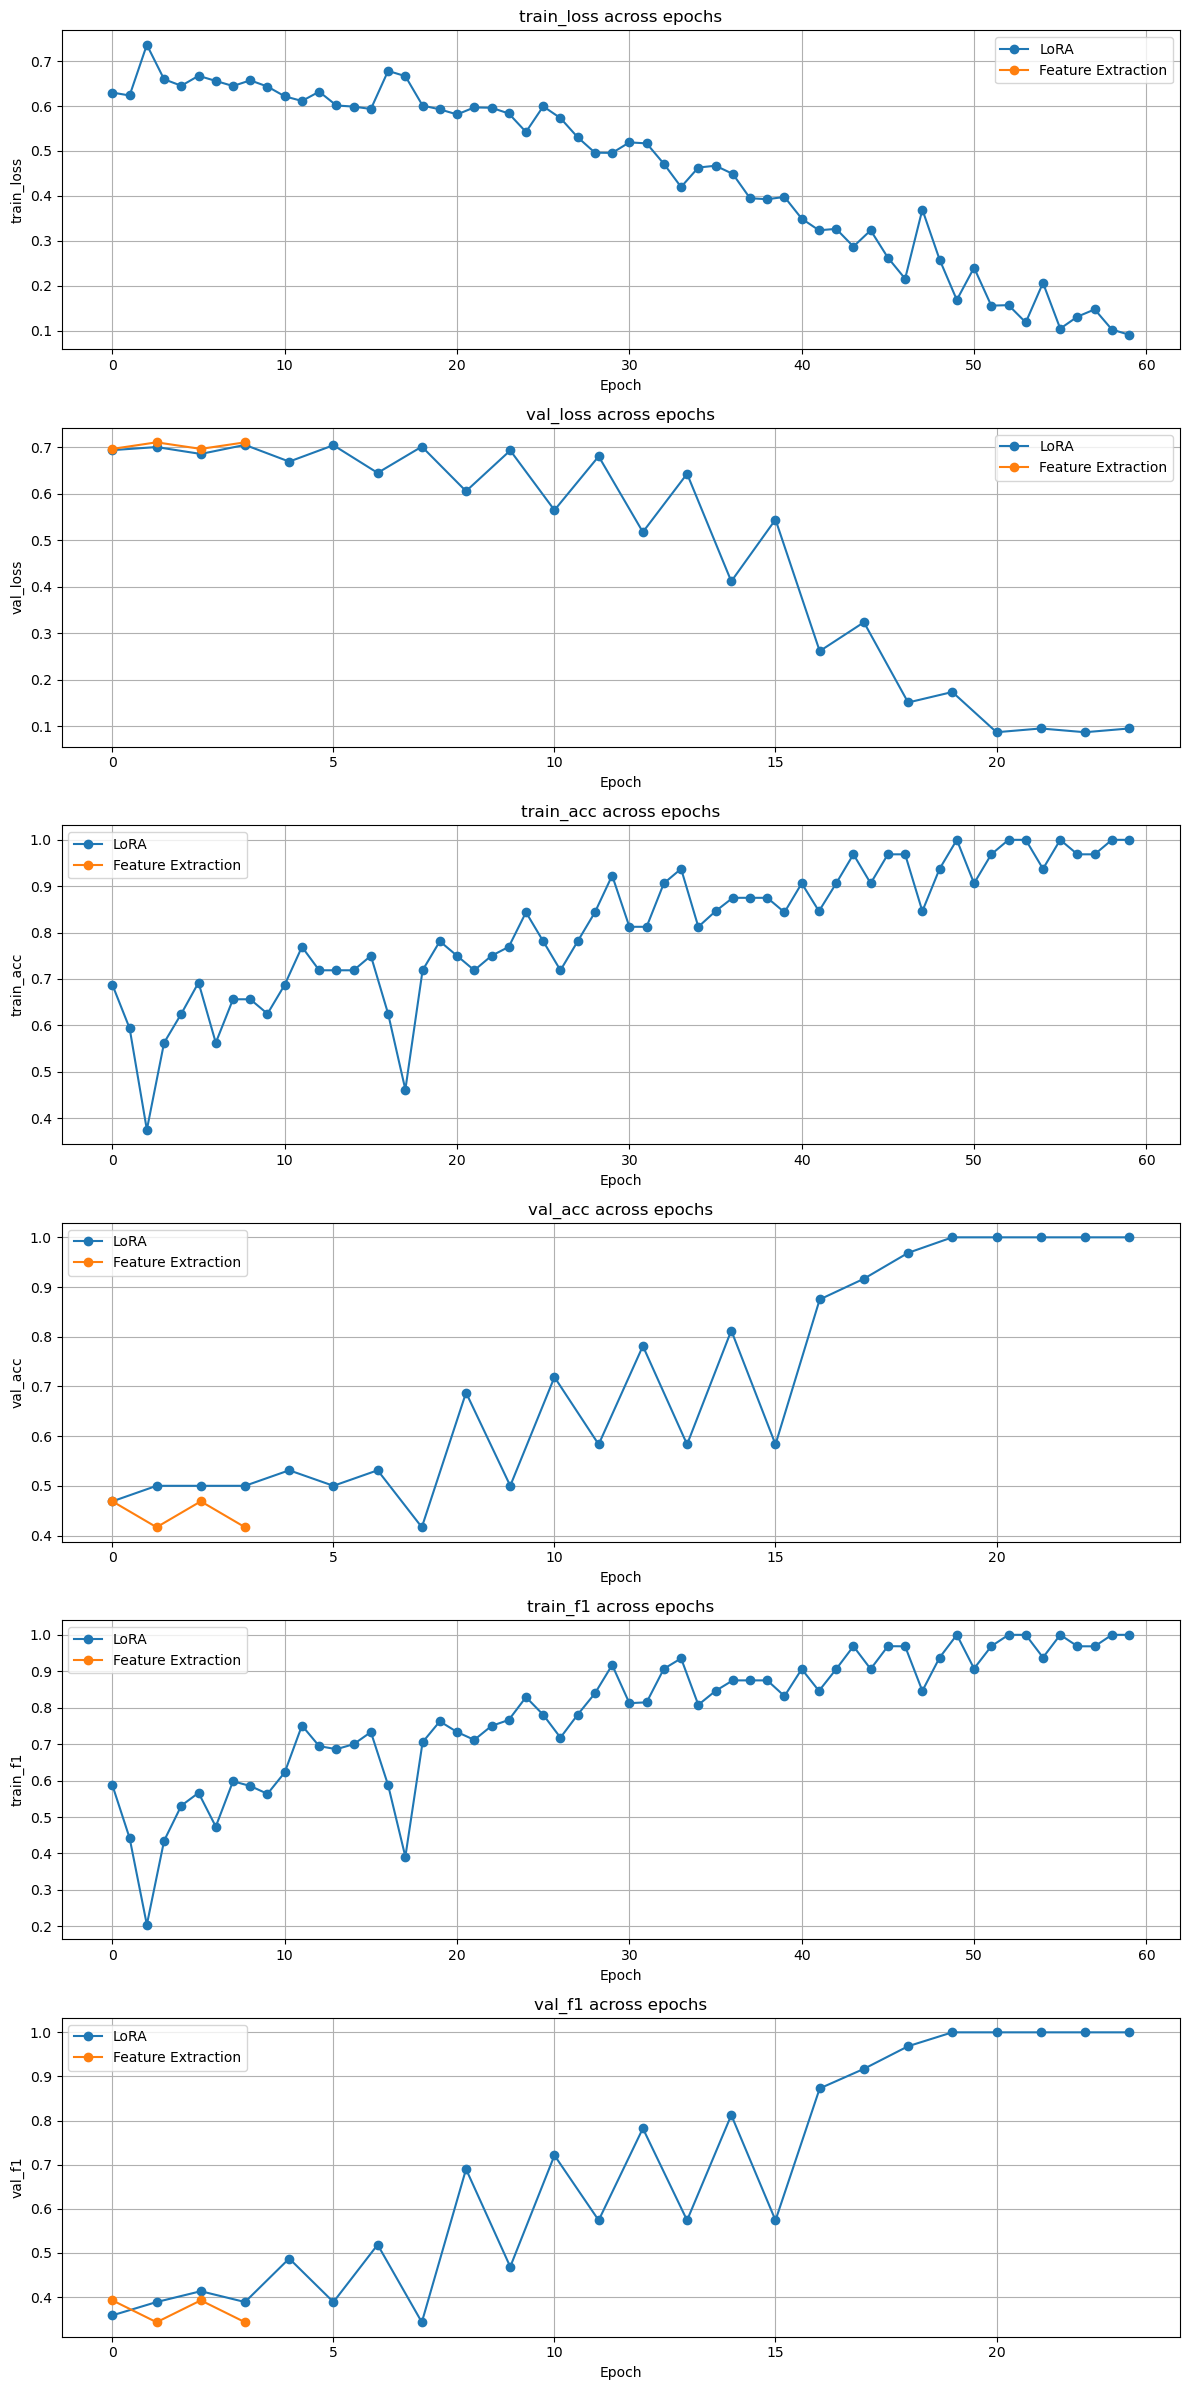

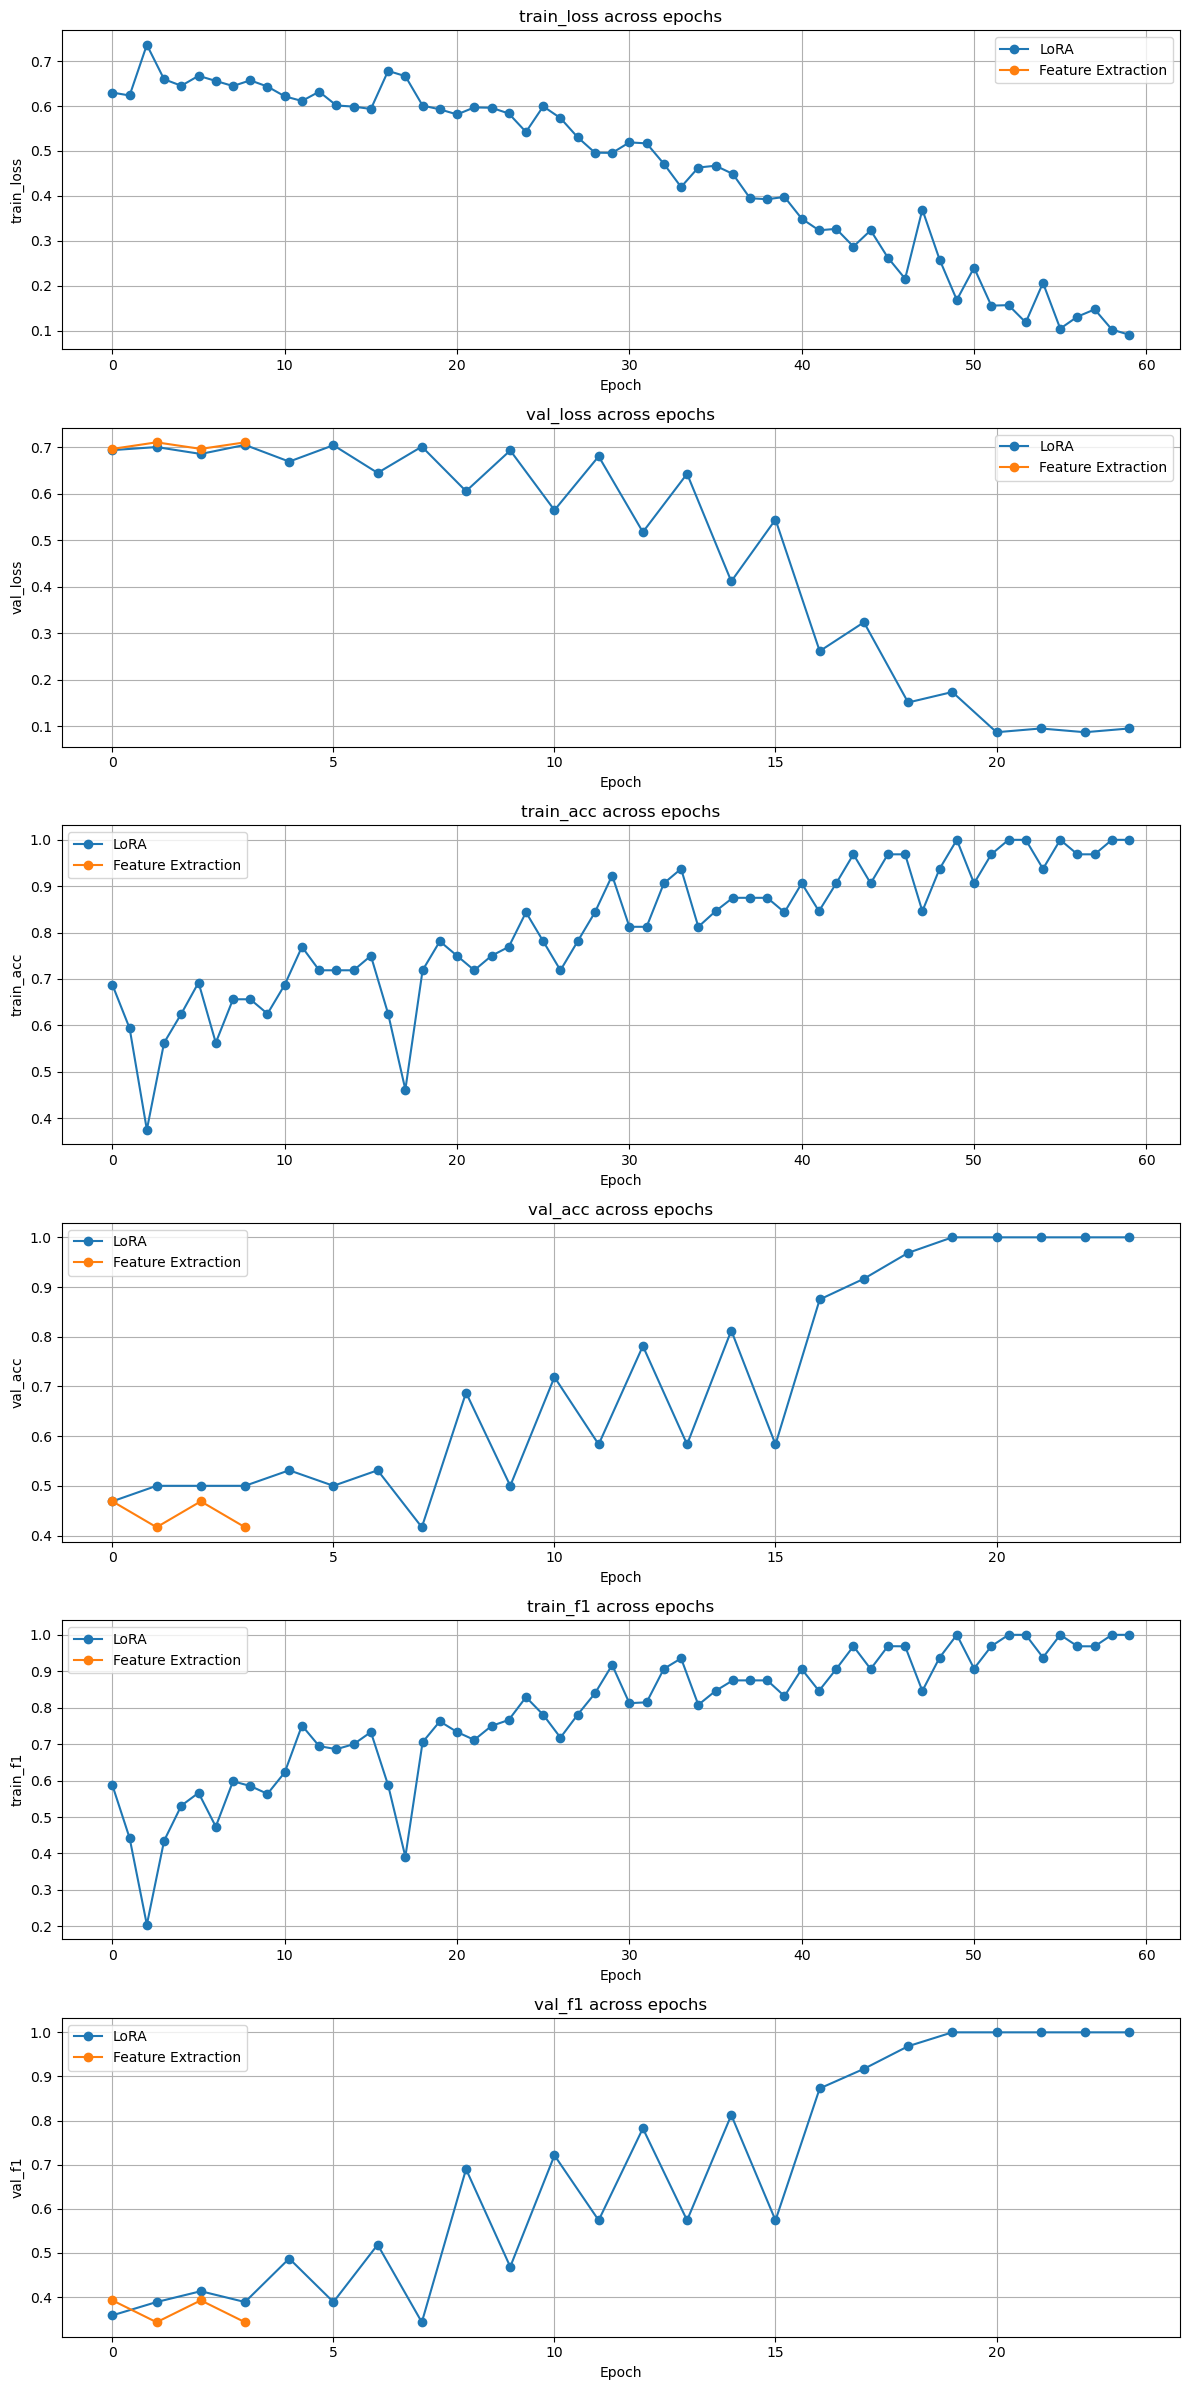

In [33]:

# Plot learning curves
print("\nPlotting learning curves...")

helpers.plot_learning_curves(lora_module.history, feature_extractor_module.history)

## Breaking down the graphs

If your stats are a little rusty, you might need a bit of refresher to make sense of the graphs above. Expand the section below for explanations of the terms used above.

<details>
    
<summary>Click to expand for stats terms!</summary>

<p>

##### What is Precision?
Precision is the ratio of correctly predicted positive observations to the total predicted positives. An example in our fruit object detection task would be the ratio of correctly predicted apples to the total predicted apples. Higher precision values are better, as they indicate that the model is making more accurate predictions.

##### What is Recall?
Recall is the ratio of correctly predicted positive observations to the true number of observations of a class. An example in our fruit object detection task would be the ratio of correctly predicted apples to the total actual apples. Higher recall values are better, as they indicate that the model is making more accurate predictions.

##### What is Confidence?
Confidence is the probability that a model assigns to a prediction. In our fruit object detection task, the confidence is the probability that a model assigns to a fruit being an apple, orange, or any other fruit. Higher confidence values are better, as they indicate that the model is more certain about its predictions.

##### What is a confusion matrix?
A confusion matrix is a table that is often used to describe the performance of a classification model on a set of test data for which the true values are known. It allows the visualization of the performance of an algorithm. The confusion matrix shows the ways in which your classification model is confused when it makes predictions. It gives you insight not only into the errors being made by your classifier but more importantly the types of errors that are being made.

##### What is the F1 Confidence Curve?
The F1 Confidence Curve is a plot of the F1 score against the confidence threshold. The F1 score is the harmonic mean of precision and recall, and it is a measure of a model's accuracy. The confidence threshold is the minimum confidence level that a model must have in order to make a prediction. The F1 Confidence Curve is used to determine the optimal confidence threshold for a model. The curve shows how the F1 score changes as the confidence threshold is varied. The goal is to find the confidence threshold that maximizes the F1 score. The highest point on the curve tells you the optimal confidence threshold where the model strikes the best balance between precision and recall. In our fruit object detection task, the F1 Confidence Curve would show how the F1 score changes as the confidence threshold is varied for each fruit class. Higher F1 scores are better, as they indicate that the model is making more accurate predictions.

##### What is AUC?
AUC stands for Area Under the Curve. It is a performance measurement for classification problems at various threshold settings. AUC represents the degree or measure of separability. It tells how much the model is capable of distinguishing between classes. Higher AUC values are better, as they indicate that the model is better at distinguishing between classes.

</p>
</details>

#### A detailed comparison

What are our metrics actually telling us? In this experiment, the LoRA model significantly outperformed the Feature Extraction model in terms of classification accuracy and ability to learn the task, despite having vastly more trainable parameters. However, the Feature Extraction model was slightly faster during inference.

##### Performance Metrics (Accuracy, Precision, F1, AUC):

LoRA Wins: LoRA shows notably better scores across the board (Accuracy: ~48% vs 45%, Precision: ~50% vs 21%, F1: ~44% vs 28%, AUC: ~0.66 vs 0.49).
Feature Extraction Struggles: Feature Extraction's performance is quite poor, especially its Precision (0.2066) and AUC (0.4896). An AUC below 0.5 suggests the model is performing worse than random guessing at distinguishing between classes. The UndefinedMetricWarning indicates it completely failed to predict certain classes, heavily impacting the precision and F1 scores.
The pre-trained features from the frozen base model (used in Feature Extraction) were likely not sufficient or well-suited for this specific classification task. Training only the small classifier head wasn't enough to adapt. LoRA, by adapting parameters within the main Transformer blocks, was able to learn task-specific patterns more effectively, leading to better discrimination between classes.

##### Trainable Parameters:

There's a massive difference: LoRA trained 886,274 parameters, while Feature Extraction only trained 1,538.
This highlights the core difference in the techniques. Feature Extraction is extremely parameter-efficient during training as it only updates the final layer. LoRA injects trainable low-rank matrices into the model, resulting in significantly more parameters to train compared to Feature Extraction, but still vastly fewer than full fine-tuning the entire base model. In this case, the extra trainable parameters used by LoRA were crucial for achieving better performance.

##### Inference Time:

Feature Extraction Faster: Feature Extraction was slightly faster (0.0236s vs 0.0381s).
This is expected. LoRA adds computational steps through its adapter matrices during the forward pass, slightly increasing inference time compared to just running the base model and a simple classifier. The difference here is small, but it could be more significant with larger models or longer sequences.

##### Learning Curves:

LoRA Learned: LoRA's curves improve quite a bit, which aligns perfectly with its better evaluation metrics. It shows the model was successfully learning and reducing loss/improving accuracy over the training epochs.
Feature Extraction Stagnated: The pretty flat curves for Feature Extraction confirm its inability to learn effectively from this data just by training the classifier. The model likely plateaued very early in training.

For this specific dataset and task, Feature Extraction proved inadequate. While extremely lightweight in terms of trainable parameters and slightly faster at inference, it failed to learn effectively, resulting in poor performance. LoRA provided a much better trade-off. Although it involved training significantly more parameters (though still far fewer than full fine-tuning) and had slightly slower inference, it successfully adapted the base model to the task, leading to substantially better classification performance and demonstrating clear learning during training. The results suggest the need for adapting more than just the final layer for this particular problem.

##### Is Feature Extraction Just Bad?

Feature Extraction might be preferable to LoRA when the downstream task is extremely similar to the model's pre-training objective, meaning the existing features require very little adaptation, and computational resources for training are exceptionally limited. In such cases, the simplicity and minimal training cost of Feature Extraction could outweigh the potential performance gains from LoRA's more complex adaptation.

### 8. Run inference

Finally, let's try out our models on some sample text. We will use the same sample text for both models to see how they perform on the same input.

#### 8.1 Run the inference

We've broken out the inference process into a separate function to keep the code clean and organized.

In [34]:
# For a one-time prediction, uncomment the two lines below.
sample_text = "I love cereal."
helpers.run_inference_on_text(
    sample_text, lora_model, feature_extractor_model, tokenizer, device, id2label
)


RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cpu and cuda:0! (when checking argument for argument index in method wrapper_CUDA__index_select)

In [17]:
# Interactive demo function
def interactive_demo(lora_model, feature_model, tokenizer, device, id2label):
    """Run an interactive demo that lets users enter text and see predictions"""
    print("\n" + "=" * 50)
    print("Interactive Model Demo")
    print("=" * 50)
    print("Enter text to classify (or 'quit' to exit):")

    while True:
        text = input("\nYour text: ")
        if text.lower() == "quit":
            print("Exiting demo...")
            break
        if not text.strip():
            print("Please enter some text to classify.")
            continue

        run_inference_on_text(
            text, lora_model, feature_model, tokenizer, device, id2label
        )

In [ ]:
# Example interactive usage.
# interactive_demo(lora_model, feature_extractor_model, tokenizer, device, id2label)

### 9. Conclusion

In this notebook, we implemented two transfer learning techniques for adapting a pre-trained Transformer model to a text classification task. We compared Feature Extraction and LoRA in terms of implementation complexity, performance metrics, and the number of parameters trained.

We observed that both techniques can achieve good performance, but they have different trade-offs in terms of efficiency and flexibility. Feature Extraction is simpler to implement and requires fewer resources, while LoRA offers more flexibility and can achieve better performance with fewer trainable parameters.

### Bonus Exercise
If you want to take this notebook a step further, try the following:
* Experiment with different pre-trained models from Hugging Face's model hub. Try using a larger model like `bert-base-uncased` or a more specialized model like `roberta-base`.
* Explore other NLP tasks, such as Named Entity Recognition (NER) or Question Answering (QA), using the same techniques.
* Try using different datasets from the Hugging Face datasets library. You can find a wide variety of datasets for different NLP tasks [here](https://huggingface.co/datasets).